Задача инженера ИИ

1. Нати больное место на предприятии, которое в ручном режими решть не эффективно
2. Сформировать требования к разрабатываемому продукту
3. Попытаться найти соответствующие датасеты
4. Если таких датасетов нет, то подготовить датасет самому
5. Собрали 5000 примеров с дефектами, надо провести аннотирование (указать ответы)
6. Нужно решить две задачи: 
* классификация - определить есть дефект или нет
* сегментация - найти область дефекта
7. Обнаружили проблему, что каждый специалист видит дефекты по-разному, разметку выполнить сложно
8. Надо выработать объективную аннотацию
9. На основе одинаковости причин возникновения дефектов от 7 типов пришли к 4.
10. Одну картинку размечают два разных человека, независимо друг от друга. Если возникает спор, то картинка отдается на оценку третьему, более опытному сотруднику, который выносит решение в пользу одного из ответов или предлагает свой.
11. Собрали больше примеров металла без дефекта, но с выделяющимися признаками (капли масла или грязи, окалина, маркировка, металл с рифлением) - стало 12500 примеров
12. Создание baseline-модели, показал себя хорошо, прирост эффективности имеется 
13. Подготовка данных теста и трейна (удаление дубликатов, распределение в выборки по соотношениям)
14. Выбор подходящей метрики. Метрика accuracy не подходит, тк слишком маленьких процент ложно-положительной ошибки. Оцениваем две величины:
* перебраковка (1-precision) - годный объект признается браком (распознаем ложный брак)
* недобраковка (1-recall) - пропуск брака (не распознаем истину)
15. Выбор пал на среднюю метриу Дайса (dice loss) - процент перекрытия получаемых и целевых областей **Dice = 2 * (A ∩ B) / (B + B)**
16. 


Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [4]:
data.shape

(7095, 3)

У нас 7095 и три фичи

# Разведочный анализ данных

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

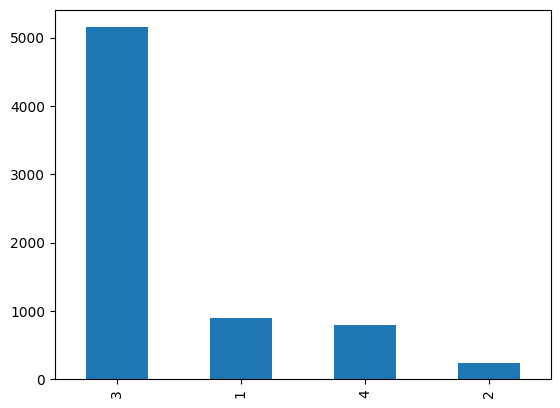

In [5]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [6]:
import cv2

Первая трансформация данных

In [7]:
l1=[]
l2=[]
# пробегаемся по каждому столбцу датасета
# tqdm визуализирует ход цикла
for img,ClassId,EncodedPixels in tqdm(data.values):
    try:
      # считываем изображения из папки
      image=cv2.imread("train_images/{}".format(img),cv2.IMREAD_COLOR)
      # меняем размер на 120х120
      image = cv2.resize(image,(120,120))
      # разделяем по спискам
      l1.append(image)
      l2.append(ClassId)
    except:
      continue




100%|██████████| 7095/7095 [00:03<00:00, 2059.14it/s] 


In [8]:
l1[0]

array([[[  2,   2,   2],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 74,  74,  74],
        [ 60,  60,  60],
        [ 64,  64,  64]],

       [[  2,   2,   2],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 73,  73,  73],
        [ 66,  66,  66],
        [ 65,  65,  65]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  2,   2,   2],
        ...,
        [ 75,  75,  75],
        [ 65,  65,  65],
        [ 61,  61,  61]],

       ...,

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [114, 114, 114],
        [114, 114, 114],
        [105, 105, 105]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [112, 112, 112],
        [109, 109, 109],
        [108, 108, 108]],

       [[  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1],
        ...,
        [117, 117, 117],
        [109, 109, 109],
        [109, 109, 109]]

In [9]:
len(l1)

351

Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

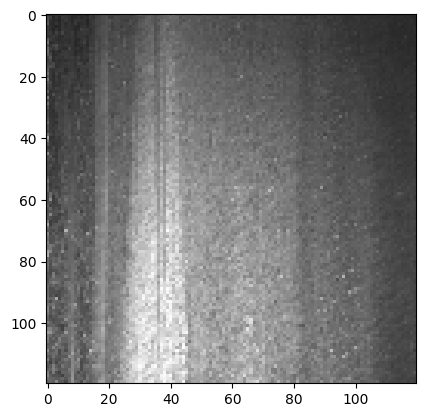

In [10]:
i = 15
plt.imshow(l1[i])

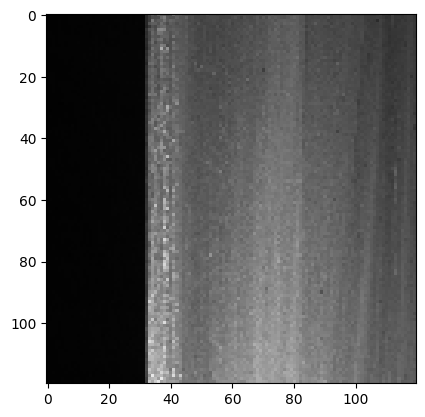

In [11]:
i = 16
plt.imshow(l1[i])

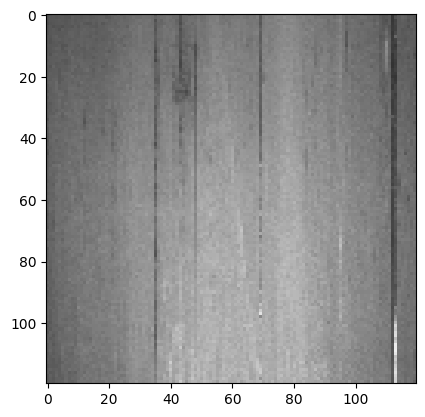

In [12]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [13]:
encoder = LabelEncoder()

X = np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)


In [14]:
# изображения из массива l1
X.shape

(351, 120, 120, 3)

In [15]:
# класс дефекта из l2
y.shape

(351,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование. <br>
дублируем изображения малопредставленных классов дефектов (1,2 и 4)

In [16]:
from imblearn.over_sampling import RandomOverSampler

reshaped_X = X.reshape(X.shape[0],-1)

oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)
X = X.reshape(-1,120,120,3)

In [17]:
X.shape

(984, 120, 120, 3)

In [18]:
y

array([2, 2, 2, 0, 2, 3, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2,
       1, 2, 2, 2, 3, 2, 3, 2, 2, 0, 3, 2, 2, 0, 2, 0, 1, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 3, 0, 2, 3, 2, 2,
       2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 0, 2,
       0, 0, 2, 3, 0, 1, 0, 2, 2, 2, 2, 3, 2, 3, 0, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 2, 2, 0, 3, 0, 2, 2, 1, 0, 2, 3, 2, 2, 2, 3, 0,
       2, 2, 0, 1, 2, 3, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 3, 0, 2, 2, 2, 2, 2, 2, 2, 3,
       0, 1, 2, 3, 2, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2,
       2, 2, 2, 3, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 2, 0, 2, 2, 0, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,

In [19]:
# категоризируем данные классов
y = to_categorical(y)
y

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]], dtype=float32)

разделим на тренировку и валидацию

In [20]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,shuffle=True)

Получаем массивы:
* x_train - тренировочные изображения (80% = 787)
* x_test - изображения на тест (20% = 197)
* y_train - "ответы" на обучение
* y_test - "ответы" на тест

In [21]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (787, 120, 120, 3)
x_test размер: (197, 120, 120, 3)
y_train размер: (787, 4)
y_test размер: (197, 4)


# Построение нейронной сети  в 3 слоя и график обучения

1 вариант. Простая сверточная сеть без Polling

In [22]:
model_1=Sequential()
model_1.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model_1.add(Flatten())
model_1.add(Dense(4,activation="softmax"))

In [23]:
model_1.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [24]:
history_1 = model_1.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 6s 665ms/step - loss: 11.1173 - accuracy: 0.2643 - val_loss: 6.6090 - val_accuracy: 0.2437
Epoch 2/10
7/7 [==============================] - 3s 409ms/step - loss: 3.3190 - accuracy: 0.3774 - val_loss: 2.5672 - val_accuracy: 0.3706
Epoch 3/10
7/7 [==============================] - 3s 422ms/step - loss: 1.9982 - accuracy: 0.4346 - val_loss: 1.0903 - val_accuracy: 0.4619
Epoch 4/10
7/7 [==============================] - 3s 420ms/step - loss: 0.9238 - accuracy: 0.5756 - val_loss: 0.8636 - val_accuracy: 0.6751
Epoch 5/10
7/7 [==============================] - 3s 429ms/step - loss: 0.7090 - accuracy: 0.6976 - val_loss: 0.8117 - val_accuracy: 0.5838
Epoch 6/10
7/7 [==============================] - 3s 438ms/step - loss: 0.5873 - accuracy: 0.7802 - val_loss: 0.5799 - val_accuracy: 0.8071
Epoch 7/10
7/7 [==============================] - 3s 385ms/step - loss: 0.4382 - accuracy: 0.8653 - val_loss: 0.4705 - val_accuracy: 0.8782
Epoch 8/10
7/7 [===

In [25]:
score_1 = model_1.evaluate(X_test, y_test, batch_size=128, verbose=2)
print(f'Test loss:, {score_1[0]}')
print(f'Test accuracy:, {score_1[1]*100:.2f} %')

2/2 - 0s - loss: 0.4015 - accuracy: 0.8782 - 272ms/epoch - 136ms/step
Test loss:, 0.40149039030075073
Test accuracy:, 87.82 %


<Axes: title={'center': 'Loss curve'}>

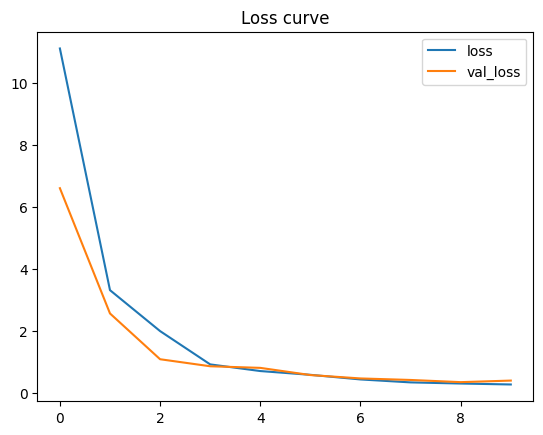

In [26]:
history_df = pd.DataFrame(history_1.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

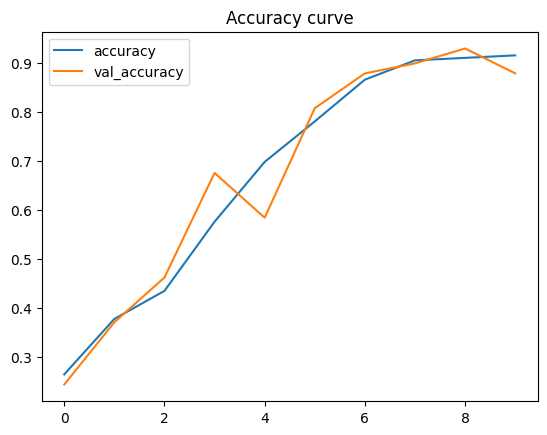

In [27]:
history_df = pd.DataFrame(history_1.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети  в 5 слоев

2 вариант. Применяем модель в 5 слоев (1 сверточный + пулинг и 2 полносвязанных)

In [28]:
model_2=Sequential([
    Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"),
    MaxPooling2D(pool_size=(3,3)),
    Flatten(),
    Dense(256,activation="relu"),
    Dense(4,activation="softmax")
])


In [29]:
model_2.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [30]:
history_2 = model_2.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    verbose=1)

Epoch 1/10
7/7 [==============================] - 5s 614ms/step - loss: 5.2057 - accuracy: 0.2872 - val_loss: 1.8514 - val_accuracy: 0.4569
Epoch 2/10
7/7 [==============================] - 4s 530ms/step - loss: 2.0845 - accuracy: 0.4244 - val_loss: 1.7668 - val_accuracy: 0.4569
Epoch 3/10
7/7 [==============================] - 4s 578ms/step - loss: 1.3013 - accuracy: 0.5083 - val_loss: 1.0663 - val_accuracy: 0.5381
Epoch 4/10
7/7 [==============================] - 4s 525ms/step - loss: 0.9332 - accuracy: 0.5972 - val_loss: 0.9140 - val_accuracy: 0.5787
Epoch 5/10
7/7 [==============================] - 4s 628ms/step - loss: 0.8048 - accuracy: 0.7027 - val_loss: 0.7824 - val_accuracy: 0.7056
Epoch 6/10
7/7 [==============================] - 4s 516ms/step - loss: 0.6947 - accuracy: 0.7433 - val_loss: 0.6826 - val_accuracy: 0.7665
Epoch 7/10
7/7 [==============================] - 4s 513ms/step - loss: 0.6075 - accuracy: 0.7726 - val_loss: 0.6009 - val_accuracy: 0.7919
Epoch 8/10
7/7 [====

In [31]:
score_2 = model_2.evaluate(X_test, y_test, batch_size=128, verbose=2)
print(f'Test loss:, {score_2[0]}')
print(f'Test accuracy:, {score_2[1]*100:.2f} %')

2/2 - 0s - loss: 0.4278 - accuracy: 0.8274 - 312ms/epoch - 156ms/step
Test loss:, 0.427816241979599
Test accuracy:, 82.74 %


<Axes: title={'center': 'Loss curve'}>

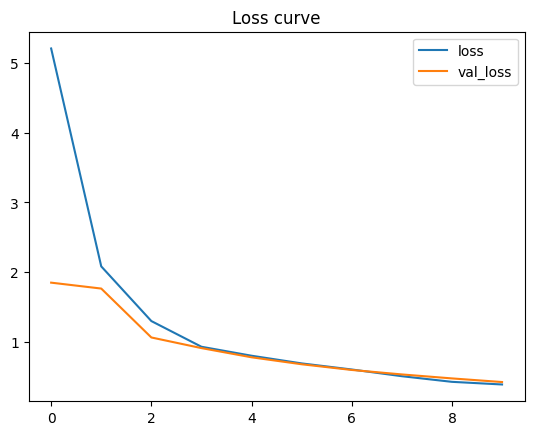

In [32]:
history_df = pd.DataFrame(history_2.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

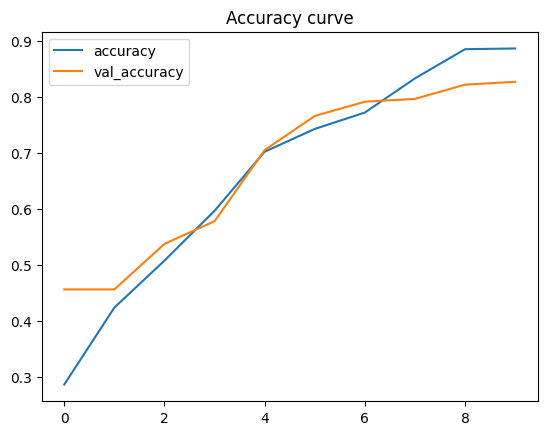

In [33]:
history_df = pd.DataFrame(history_2.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

# Построение нейронной сети в 13 слоев и обучение

3 варинат. 13 слоев: 3 сверточных слоя + пулинг

In [34]:
model_3=Sequential([
    Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"),
    MaxPooling2D(pool_size=(3,3)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D(pool_size=(3,3)),
    Conv2D(64,(3,3),activation="relu"),
    MaxPooling2D(pool_size=(4,4)),
    Flatten(),
    Dense(128,activation="relu"),
    Dropout(0.2),
    Dense(128,activation="relu"),
    Dropout(0.2),
    Dense(256,activation="relu"),
    Dense(4,activation="softmax")
])

In [35]:
# также применим защит от переобучения
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,min_delta=0.001,restore_best_weights=True)

In [36]:
model_3.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [37]:
history_3 = model_3.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),batch_size=128,
                    callbacks=[early_stopping], verbose=1)

Epoch 1/10
7/7 [==============================] - 6s 766ms/step - loss: 1.3720 - accuracy: 0.2770 - val_loss: 1.3517 - val_accuracy: 0.3706
Epoch 2/10
7/7 [==============================] - 5s 711ms/step - loss: 1.3200 - accuracy: 0.3774 - val_loss: 1.2687 - val_accuracy: 0.3909
Epoch 3/10
7/7 [==============================] - 5s 691ms/step - loss: 1.2281 - accuracy: 0.4244 - val_loss: 1.1945 - val_accuracy: 0.4416
Epoch 4/10
7/7 [==============================] - 5s 661ms/step - loss: 1.1373 - accuracy: 0.4816 - val_loss: 0.9988 - val_accuracy: 0.4975
Epoch 5/10
7/7 [==============================] - 5s 686ms/step - loss: 1.0466 - accuracy: 0.4943 - val_loss: 0.9879 - val_accuracy: 0.5279
Epoch 6/10
7/7 [==============================] - 5s 700ms/step - loss: 0.9992 - accuracy: 0.5057 - val_loss: 0.9693 - val_accuracy: 0.5228
Epoch 7/10
7/7 [==============================] - 5s 674ms/step - loss: 0.9659 - accuracy: 0.5121 - val_loss: 0.9257 - val_accuracy: 0.5431
Epoch 8/10
7/7 [====

<Axes: title={'center': 'Loss curve'}>

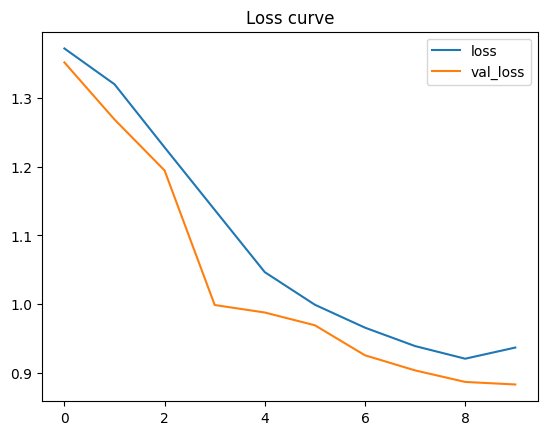

In [38]:
history_df = pd.DataFrame(history_3.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve'}>

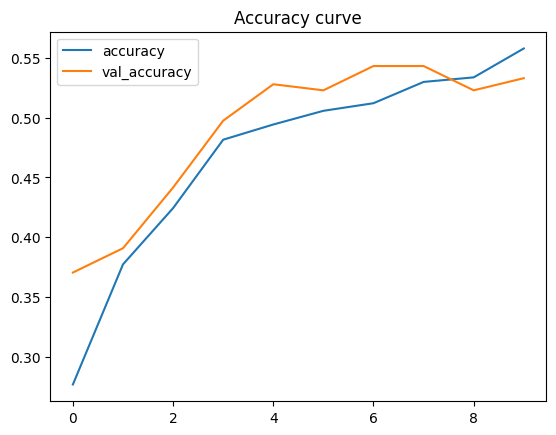

In [39]:
history_df = pd.DataFrame(history_3.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = 'Accuracy curve')

In [40]:
score_3 = model_3.evaluate(X_test, y_test, batch_size=128, verbose=2)
print(f'Test loss:, {score_3[0]}')
print(f'Test accuracy:, {score_3[1]*100:.2f} %')

2/2 - 0s - loss: 0.8832 - accuracy: 0.5330 - 491ms/epoch - 246ms/step
Test loss:, 0.883219838142395
Test accuracy:, 53.30 %


In [41]:
# from keras.models import Model

# model_3.save('saved_models/my_model_steel.h5')

In [42]:
# from keras.models import load_model

# loaded_model = load_model('saved_models/my_model_steel.h5')


# Архитектура созданной нейронной сети

In [43]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 64)        

# Тестирование на новых примерах

In [44]:
l2[:3]

[3, 3, 3]

In [45]:
X = np.array(l1[:3]) 
X = X / 255

y = encoder.fit_transform(l2[:3])
y = np.array(y)

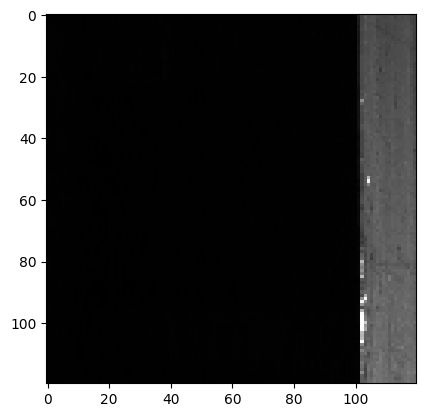

In [46]:
plt.imshow(l1[0])

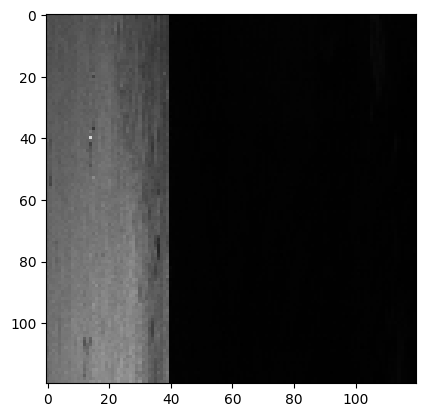

In [47]:
plt.imshow(l1[1])

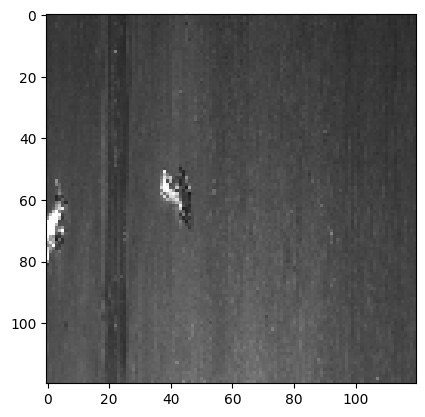

In [48]:
plt.imshow(l1[2])

In [49]:
y = to_categorical(y)
y

array([[1.],
       [1.],
       [1.]], dtype=float32)

In [50]:

predictions = model_1.predict(X)
predictions

1/1 [==============================] - 0s 127ms/step


array([[0.01326199, 0.97859496, 0.00522483, 0.00291824],
       [0.0831726 , 0.08618094, 0.6862739 , 0.14437257],
       [0.03709659, 0.01077556, 0.8451154 , 0.10701247]], dtype=float32)

Здесь три эксперимента, где мы видим, что тест № 2 был с меткой 3, но неверно идентифицировался как метка 1.

In [51]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 2, 2, 64)        

# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.